# Кластеризация по последовательности антител:

## Предварительная обработка данных

### Скачать базу данных SAbDab
https://opig.stats.ox.ac.uk/webapps/newsabdab/sabdab/archive/all/

Скачаную базу разархивируем, скрип будет работать с папкой __all_structures/chothia__
Из остальных он меньше соединений вытаскивает



### Подготовка окружения
Я буду использовать окружение __conda__  
Ниже команды для создания окружения со всеми необходимыми зависимостями:  


In [ ]:
!conda env create -f environment.yml

### Извлечение последовательностей FASTA для тяжелой и легкой цепей антитела  
Данный код извлекает аминокислотные последовательности тяжелых и легких цепей антител из файлов формата PDB в директории "all_structures/chothia1/", сохраняет их в формате FASTA в соответствующие директории "heavy_chains" и "light_chains". Для обработки файлов используется ThreadPoolExecutor, что позволяет параллельно обрабатывать несколько файлов.

In [ ]:
import re
import os
import shutil
from Bio.PDB import PDBParser, Select, PDBIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import glob
from itertools import chain
from concurrent.futures import ThreadPoolExecutor


aa_dict = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V",
}

if os.path.exists("heavy_chains"):
    shutil.rmtree("heavy_chains")

if os.path.exists("light_chains"):
    shutil.rmtree("light_chains")

os.makedirs("heavy_chains")
os.makedirs("light_chains")


class ChainSelector(Select):
    def __init__(self, chain_ids):
        self.chain_ids = chain_ids

    def accept_chain(self, chain):
        return chain.get_id() in self.chain_ids


def extract_chains(pdb_file, chain_ids):
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure("temp", pdb_file)
    except ValueError as e:
        print(f"Error processing {pdb_file}: {e}")
        return []

    chains = []

    for chain in structure.get_chains():
        if chain.get_id() in chain_ids:
            seq = ""
            for residue in chain.get_residues():
                if residue.get_resname() in aa_dict:
                    seq += aa_dict[residue.get_resname()]
            matches = re.findall(r"\d+", str(chain.get_full_id()))
            if matches:
                chain_id = matches[0]
            else:
                chain_id = "unknown"
            filename = os.path.basename(pdb_file)
            record_id = f"{filename}_{chain_id}"
            chains.append(SeqRecord(Seq(seq), id=record_id, description=""))

    return chains


def process_pdb_file(pdb_file):
    heavy_chains = extract_chains(pdb_file, ["H"])
    light_chains = extract_chains(pdb_file, ["L"])
    filename = os.path.splitext(os.path.basename(pdb_file))[0]
    SeqIO.write(heavy_chains, f"heavy_chains/{filename}_heavy.fasta", "fasta")
    SeqIO.write(light_chains, f"light_chains/{filename}_light.fasta", "fasta")

def main():
    if os.path.exists("heavy_chains"):
        shutil.rmtree("heavy_chains")

    if os.path.exists("light_chains"):
        shutil.rmtree("light_chains")

    os.makedirs("heavy_chains")
    os.makedirs("light_chains")

    pdb_files = glob.glob("all_structures/chothia/*.pdb")

    with ThreadPoolExecutor() as executor:
        executor.map(process_pdb_file, pdb_files)

if __name__ == "__main__":
    main()

### Удаление пустых файлов fasta  
Код проверяет папки "heavy_chains" и "light_chains" на наличие пустых файлов формата FASTA и удаляет их. Если пустых файлов не найдено, выводится соответствующее сообщение. Если были удалены файлы, выводится информация о количестве удаленных файлов и их пути.

In [ ]:
import os

folders = ['heavy_chains', 'light_chains']
deleted_files = []
count_deleted_files = 0

for folder in folders:
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.fasta'):
                file_path = os.path.join(root, file)
                if os.stat(file_path).st_size == 0:
                    os.remove(file_path)
                    deleted_files.append(file_path)
                    count_deleted_files += 1

if count_deleted_files == 0:
    print("No empty .fasta files found for deletion")
else:
    print("Deleted {} empty .fasta files:".format(count_deleted_files))
    for file in deleted_files:
        print(file)


## Кластеризация 

### Кластеризация с помощью DBSCAN  
Код кластеризует последовательности аминокислотных остатков легких и тяжелых цепей антител, используя алгоритм DBSCAN. Функция read_fasta_file читает файлы в формате FASTA и возвращает строку с последовательностью аминокислотных остатков. Функция distance вычисляет расстояние между двумя последовательностями аминокислотных остатков.  

Функция cluster_antibodies выполняет кластеризацию последовательностей антител, используя DBSCAN, и возвращает имена файлов, метки кластеров и матрицу расстояний между последовательностями. Код также выводит прогресс выполнения и сообщения о кластеризации легких и тяжелых цепей. 
 
Можно изменить параметры алгоритма DBSCAN, такие как __eps__ (радиус соседства) и __min_samples__ (минимальное количество точек в соседстве). Это может помочь алгоритму лучше различать кластеры в данных.

In [19]:
import os
import sys
from Bio import SeqIO
from sklearn.cluster import DBSCAN
import numpy as np


# Путь к папке с файлами light_chain
light_path = "light_chains"

# Путь к папке с файлами heavy_chain
heavy_path = "heavy_chains"

# Функция для чтения файлов в формате FASTA и получения последовательности аминокислотных остатков
def read_fasta_file(file_path):
    with open(file_path, "r") as f:
        seq_record = SeqIO.read(f, "fasta")
        return str(seq_record.seq)

# Функция для вычисления расстояния между последовательностями аминокислотных остатков
def distance(seq1, seq2):
    return np.sum([1 for a, b in zip(seq1, seq2) if a != b])

# Функция для кластеризации последовательностей антител
def cluster_antibodies(fasta_path):
    
    files = os.listdir(fasta_path)
    fasta_files = [f for f in files if f.endswith(".fasta")]

    sequences = [read_fasta_file(os.path.join(fasta_path, f)) for f in fasta_files]
    distances = np.zeros((len(sequences), len(sequences)))

    count = 0
    n_sequences = len(sequences)

    # Кластеризация последовательностей антител
    for i, seq1 in enumerate(sequences):
        for j, seq2 in enumerate(sequences):
            distances[i][j] = distance(seq1, seq2)

        count += 1
        progress = count / n_sequences
        sequence_progress = "[{:{}}] {:>3}%".format("=" * int(20 * progress), 20, int(100 * progress))
        sys.stdout.write('\r' + 'Processed chains: {} / {} {}'.format(count, n_sequences, sequence_progress))
        sys.stdout.flush()

 # Кластеризация с помощью DBSCAN
    clustering = DBSCAN(eps=5, min_samples=3, metric='precomputed').fit(distances)

    cluster_labels = clustering.labels_
    file_names = np.array(fasta_files)

    return file_names, cluster_labels, distances



print("Clustering light chains...")
light_files, light_clusters, light_distances = cluster_antibodies(light_path)

print("\nClustering heavy chains...")
heavy_files, heavy_clusters, heavy_distances = cluster_antibodies(heavy_path)


Clustering light chains...
Processed chains: 4198 / 4198 [====================] 100%
Clustering heavy chains...
Processed chains: 4488 / 4488 [====================] 100%

### Иерархическая кластеризация  

Все тоже самое, но иерархическая кластеризация антител по последовательности, используя агломеративный подход и метод Уорда.

In [20]:
import os
import sys
from Bio import SeqIO
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Путь к папке с файлами light_chain
light_path = "light_chains"

# Путь к папке с файлами heavy_chain
heavy_path = "heavy_chains"

# Функция для чтения файлов в формате FASTA и получения последовательности аминокислотных остатков
def read_fasta_file(file_path):
    with open(file_path, "r") as f:
        seq_record = SeqIO.read(f, "fasta")
        return str(seq_record.seq)

# Функция для вычисления расстояния между последовательностями аминокислотных остатков
def distance(seq1, seq2):
    return np.sum([1 for a, b in zip(seq1, seq2) if a != b])

def cluster_antibodies_hierarchical(fasta_path, n_clusters):
    # Получение списка файлов с последовательностями антител в формате FASTA
    files = os.listdir(fasta_path)
    fasta_files = [f for f in files if f.endswith(".fasta")]

    # Чтение последовательностей аминокислотных остатков и вычисление расстояний между ними
    sequences = [read_fasta_file(os.path.join(fasta_path, f)) for f in fasta_files]
    distances = np.zeros((len(sequences), len(sequences)))

    # Инициализация переменной счетчика
    count = 0
    n_sequences = len(sequences)

    # Вычисление матрицы расстояний между последовательностями антител
    for i, seq1 in enumerate(sequences):
        for j, seq2 in enumerate(sequences):
            distances[i][j] = distance(seq1, seq2)
        # Увеличение переменной счетчика на 1 и вывод динамической строки с процентами
        count += 1
        progress = count / n_sequences
        sequence_progress = "[{:{}}] {:>3}%".format("=" * int(20 * progress), 20, int(100 * progress))
        sys.stdout.write('\r' + 'Processed chains: {} / {} {}'.format(count, n_sequences, sequence_progress))
        sys.stdout.flush()

    # Иерархическая кластеризация с использованием метода Уорда
    condensed_distances = squareform(distances, checks=False)
    linkage_matrix = linkage(condensed_distances, method='ward')

    # Определение кластеров на основе заданного количества кластеров
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Запись результатов кластеризации в numpy массивы
    file_names = np.array(fasta_files)

    return file_names, cluster_labels, distances

# Задаем количество кластеров для иерархической кластеризации
n_clusters = 5

# Кластеризация последовательностей антител для цепей легких
print("Clustering light chains...")
light_files, light_clusters, light_distances = cluster_antibodies_hierarchical(light_path, n_clusters)

# Кластеризация последовательностей антител для цепей тяжелых
print("\nClustering heavy chains...")
heavy_files, heavy_clusters, heavy_distances = cluster_antibodies_hierarchical(heavy_path, n_clusters)

Clustering light chains...
Processed chains: 4198 / 4198 [====================] 100%
Clustering heavy chains...
Processed chains: 4488 / 4488 [====================] 100%

### Kластеризация с использованием K-means  
Все тоже самое, но другой способ кластеризации

In [27]:
import os
import sys
import numpy as np
from Bio import SeqIO
from sklearn.cluster import KMeans

# Путь к папке с файлами light_chain
light_path = "light_chains"

# Путь к папке с файлами heavy_chain
heavy_path = "heavy_chains"

# Функция для чтения файлов в формате FASTA и получения последовательности аминокислотных остатков
def read_fasta_file(file_path):
    with open(file_path, "r") as f:
        seq_record = SeqIO.read(f, "fasta")
        return str(seq_record.seq)

# Функция для вычисления расстояния между последовательностями аминокислотных остатков
def distance(seq1, seq2):
    return np.sum([1 for a, b in zip(seq1, seq2) if a != b])

def cluster_antibodies_kmeans(fasta_path, n_clusters=2):
    # Получение списка файлов с последовательностями антител в формате FASTA
    files = os.listdir(fasta_path)
    fasta_files = [f for f in files if f.endswith(".fasta")]

    # Чтение последовательностей аминокислотных остатков и вычисление расстояний между ними
    sequences = [read_fasta_file(os.path.join(fasta_path, f)) for f in fasta_files]
    distances = np.zeros((len(sequences), len(sequences)))

    # Инициализация переменной счетчика
    count = 0
    n_sequences = len(sequences)

    # Вычисление расстояний между последовательностями
    for i, seq1 in enumerate(sequences):
        for j, seq2 in enumerate(sequences):
            distances[i][j] = distance(seq1, seq2)
        count += 1
        progress = count / n_sequences
        sequence_progress = "[{:{}}] {:>3}%".format("=" * int(20 * progress), 20, int(100 * progress))
        sys.stdout.write('\r' + 'Processed chains: {} / {} {}'.format(count, n_sequences, sequence_progress))
        sys.stdout.flush()

    # Кластеризация с помощью K-means
    clustering = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(distances)

    # Запись результатов кластеризации в numpy массивы
    cluster_labels = clustering.labels_
    file_names = np.array(fasta_files)

    return file_names, cluster_labels, distances

print("Clustering light chains with K-means...")
light_files_kmeans, light_clusters_kmeans, light_distances_kmeans = cluster_antibodies_kmeans(light_path, n_clusters=2)

print("\nClustering heavy chains with K-means...")
heavy_files_kmeans, heavy_clusters_kmeans, heavy_distances_kmeans = cluster_antibodies_kmeans(heavy_path, n_clusters=2)

Clustering light chains with K-means...
Processed chains: 4198 / 4198 [====================] 100%
Clustering heavy chains with K-means...
Processed chains: 4488 / 4488 [====================] 100%

## Анализ кластеров:  
Теперь, когда вы получили метки кластеров для каждой из последовательностей антител, можно проанализировать качество кластеризации и интерпретировать результаты.  Для результатов разных кластеризаций нужно запускать код с ними заново.

Для начала можно определить количество кластеров и количество последовательностей антител в каждом кластере. Это может быть сделано с помощью следующего кода:  

Этот код выводит количество кластеров и размер каждого кластера, что может помочь оценить, насколько хорошо данные делятся на кластеры.

In [28]:
from collections import Counter

def print_cluster_info(cluster_labels):
    cluster_counter = Counter(cluster_labels)
    n_clusters = len(cluster_counter.keys())
    print("Number of clusters:", n_clusters)
    print("Clusters and their sizes:", cluster_counter)

print("Light chains clustering info:")
print_cluster_info(light_clusters)

print("\nHeavy chains clustering info:")
print_cluster_info(heavy_clusters)


Light chains clustering info:
Number of clusters: 5
Clusters and their sizes: Counter({5: 1994, 1: 1005, 2: 434, 4: 388, 3: 377})

Heavy chains clustering info:
Number of clusters: 5
Clusters and their sizes: Counter({4: 2573, 2: 811, 5: 467, 1: 391, 3: 246})


Визуализируйте полученные кластеры с помощью тепловой карты

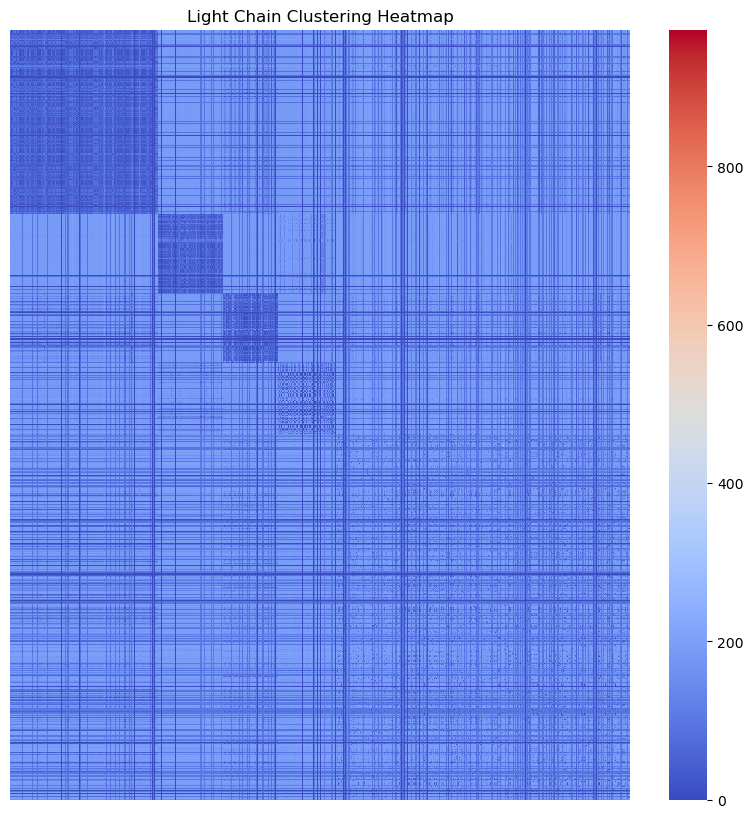

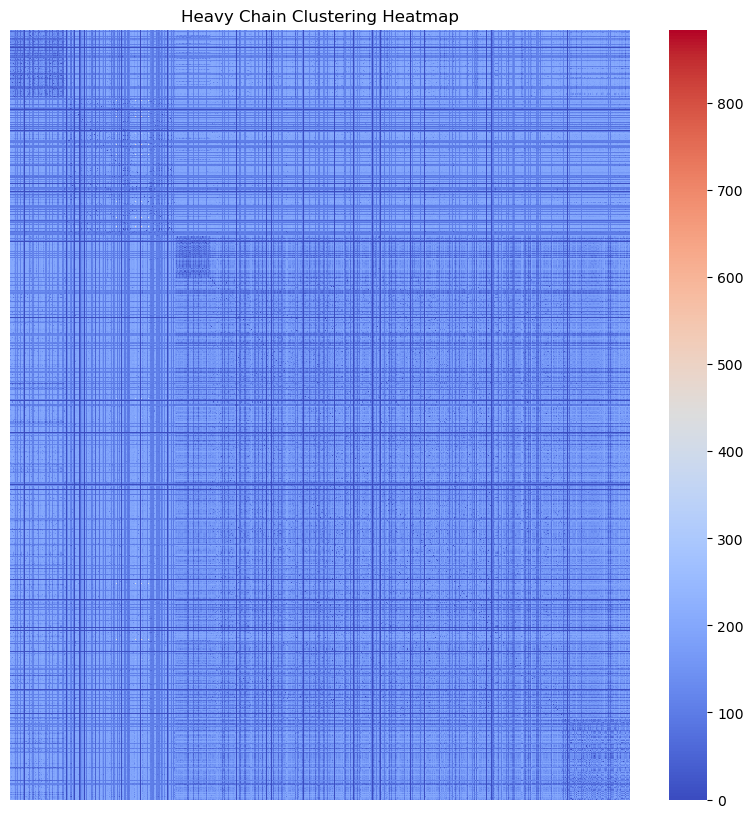

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(distances, labels, title):
    # Sort the distance matrix by cluster labels
    sorted_indices = np.argsort(labels)
    sorted_distances = distances[sorted_indices, :][:, sorted_indices]

    plt.figure(figsize=(10, 10))
    sns.heatmap(sorted_distances, cmap="coolwarm", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()

# Plot heatmaps for light and heavy chains
plot_heatmap(light_distances, light_clusters, "Light Chain Clustering Heatmap")
plot_heatmap(heavy_distances, heavy_clusters, "Heavy Chain Clustering Heatmap")


Визуализируйте полученные кластеры с помощью дендрограммы

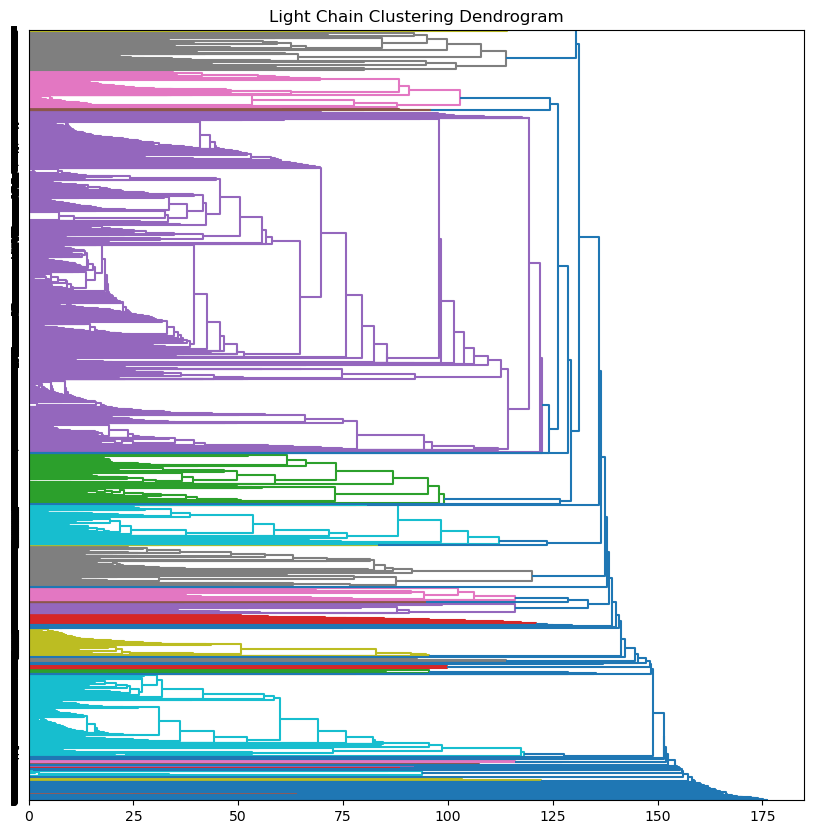

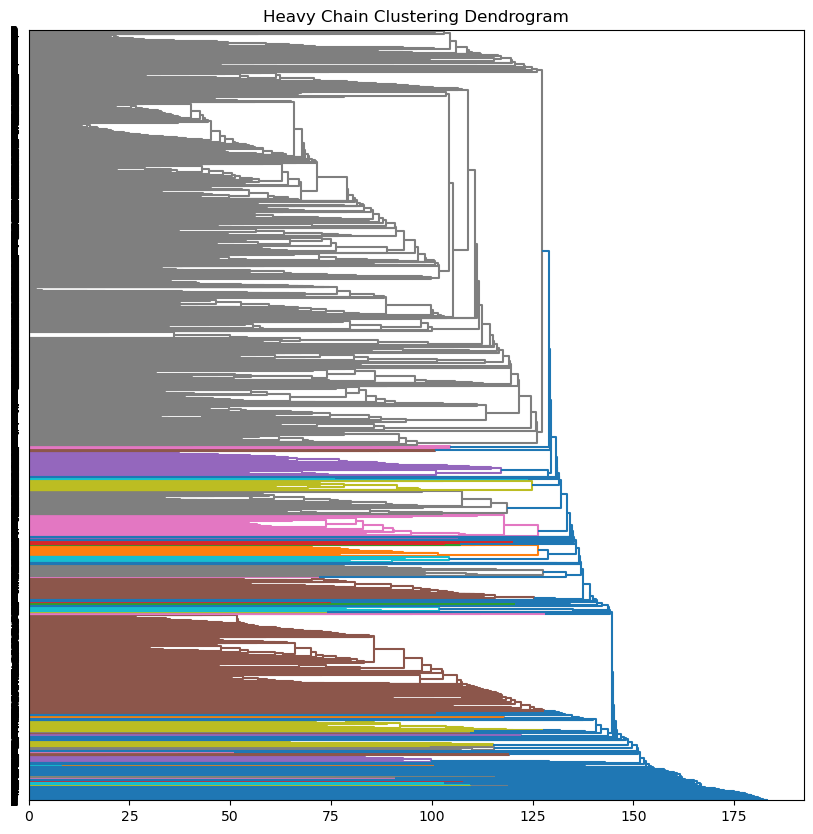

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

def plot_dendrogram(distances, labels, title):
    # Convert the square distance matrix to a condensed distance matrix
    condensed_distances = squareform(distances)

    # Compute the linkage matrix
    Z = linkage(condensed_distances, method="average")

    plt.figure(figsize=(10, 10))
    dendrogram(Z, labels=labels, orientation="right", leaf_font_size=10)
    plt.title(title)
    plt.show()

# Plot dendrograms for light and heavy chains
plot_dendrogram(light_distances, light_clusters, "Light Chain Clustering Dendrogram")
plot_dendrogram(heavy_distances, heavy_clusters, "Heavy Chain Clustering Dendrogram")


Затем, для визуализации кластеров, можно использовать метод главных компонент (PCA) для уменьшения размерности данных и их отображения на двумерной плоскости. Это может быть сделано с помощью следующего кода:

PCA plot for light chains:


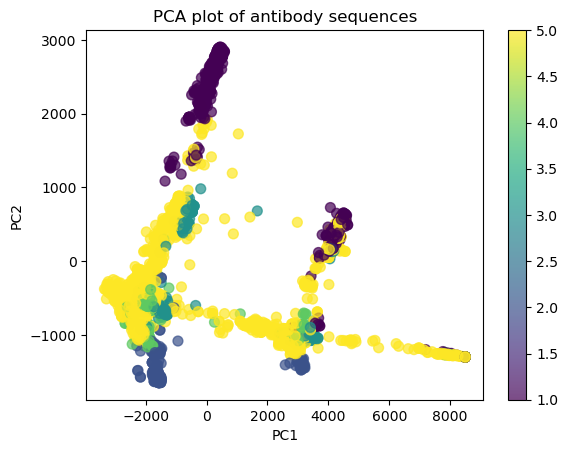

PCA plot for heavy chains:


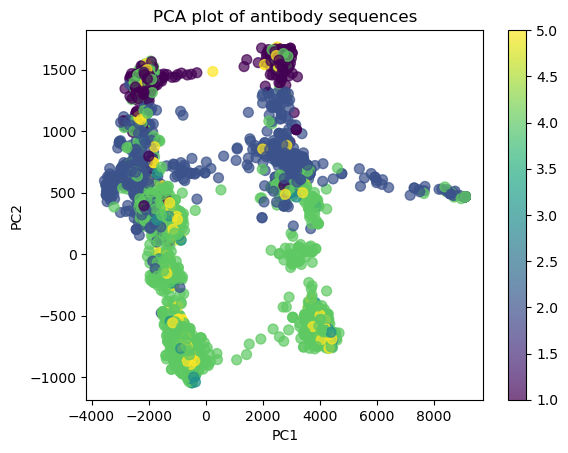

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(sequences, cluster_labels):
    pca = PCA(n_components=2)
    coords = pca.fit_transform(sequences)

    plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA plot of antibody sequences")
    plt.colorbar()
    plt.show()

print("PCA plot for light chains:")
plot_clusters(light_distances, light_clusters)

print("PCA plot for heavy chains:")
plot_clusters(heavy_distances, heavy_clusters)


PCA plot for light chains:


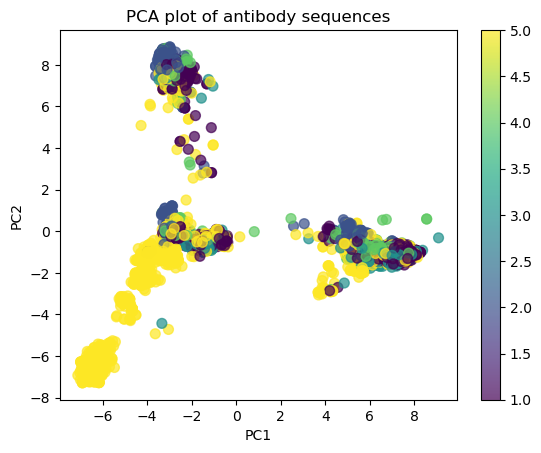

PCA plot for heavy chains:


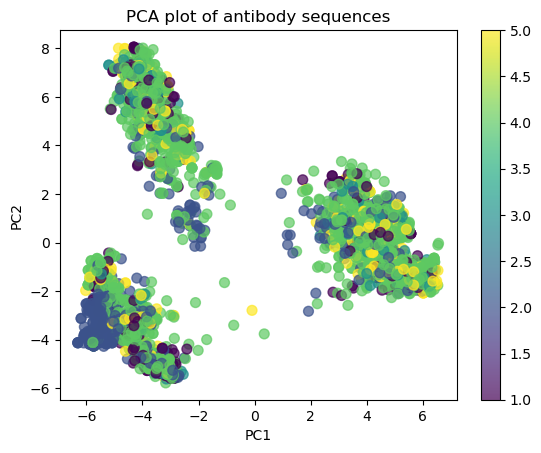

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_sequences(sequences, kmer_size=3):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(kmer_size, kmer_size))
    kmer_vectors = vectorizer.fit_transform(sequences)
    return kmer_vectors.toarray()

light_sequences = [read_fasta_file(os.path.join(light_path, f)) for f in light_files]
heavy_sequences = [read_fasta_file(os.path.join(heavy_path, f)) for f in heavy_files]

light_vectors = vectorize_sequences(light_sequences)
heavy_vectors = vectorize_sequences(heavy_sequences)

print("PCA plot for light chains:")
plot_clusters(light_vectors, light_clusters)

print("PCA plot for heavy chains:")
plot_clusters(heavy_vectors, heavy_clusters)